In [ ]:
# Load dependencies
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from astropy.io import fits
import time
from cosmos_helper_funcs import *
# use nonuniformity.py from 1 folder up
from nonuniformity import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
home_dir = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonuniformity/Raw Images'
gray_stacks = get_stacks(home_dir + '/Light Images')
dark_stacks = get_stacks(home_dir + '/Dark Images')
dsnu_stacks = get_stacks(home_dir + '/DSNU Images')
gray_stack_1 = gray_stacks[0]['imagestack']
dark_stack_1 = dark_stacks[0]['imagestack']
dsnu_stack_1 = dsnu_stacks[0]['imagestack']
# gray_stack_2 = gray_stacks[1]['imagestack']
# dark_stack_2 = dark_stacks[1]['imagestack']
# dsnu_stack_2 = dsnu_stacks[1]['imagestack']

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonuniformity/Raw Images/Light Images/CMS_RS_light_4000ms_-25C 2024-10-05 15_53_21.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonuniformity/Raw Images/Dark Images/CMS_RS_dark_4000ms_-25C 2024-10-05 15_52_27.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Nonuniformity/Raw Images/DSNU Images/CMS_RS_dark_1us_-25C 2024-10-05 14_57_27.fits


In [24]:
# Correct for any light source fluctuation between ramp days
# gray_stack_2 = gray_stack_2 * np.nanmean(gray_stack_1) / np.nanmean(gray_stack_2)
# gray_stack = np.concatenate((gray_stack_1, gray_stack_2), axis=0)
# dark_stack = np.concatenate((dark_stack_1, dark_stack_2), axis=0)
# dsnu_stack = np.concatenate((dsnu_stack_1, dsnu_stack_2), axis=0)
gray_stack = gray_stack_1
dark_stack = dark_stack_1
dsnu_stack = dsnu_stack_1

In [25]:
cms_defect_map_calibration_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Defect Maps/defect_map_calibration_CMS.fits'
cms_defect_map_calibration = fits.getdata(cms_defect_map_calibration_file)
cms_defect_map_dark_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Final Data Products/Calibration/Defect Maps/defect_map_dark_CMS.fits'
cms_defect_map_dark = fits.getdata(cms_defect_map_dark_file)


In [26]:
gray_stack_imgs = gray_stack * cms_defect_map_calibration * cms_defect_map_dark
dark_stack_imgs = dark_stack * cms_defect_map_calibration * cms_defect_map_dark
dsnu_stack_imgs = dsnu_stack * cms_defect_map_calibration * cms_defect_map_dark

/Users/layden/Documents/Image-Sensor-Testing/nonuniformity.py:34: RuntimeWarning: Mean of empty slice
  self.gray_avg_img = np.nanmean(self.gray_imagestack, axis=0)
/Users/layden/Documents/Image-Sensor-Testing/nonuniformity.py:35: RuntimeWarning: Mean of empty slice
  self.dark_avg_img = np.nanmean(self.dark_imagestack, axis=0)
/Users/layden/Documents/Image-Sensor-Testing/nonuniformity.py:36: RuntimeWarning: Mean of empty slice
  self.dsnu_avg_img = np.nanmean(self.dsnu_imagestack, axis=0)
/Users/layden/Documents/Image-Sensor-Testing/nonuniformity.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.gray_temp_var_img = np.nanvar(self.gray_imagestack, axis=0, ddof=1)
/Users/layden/Documents/Image-Sensor-Testing/nonuniformity.py:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.dark_temp_var_img = np.nanvar(self.dark_imagestack, axis=0, ddof=1)
/Users/layden/Documents/Image-Sensor-Testing/nonuniformity.py:46: RuntimeWarning: Degrees of freedom <= 0 for slice.
  se

PRNU:  1.3363379876432746
DSNU:  1.9043937739517665


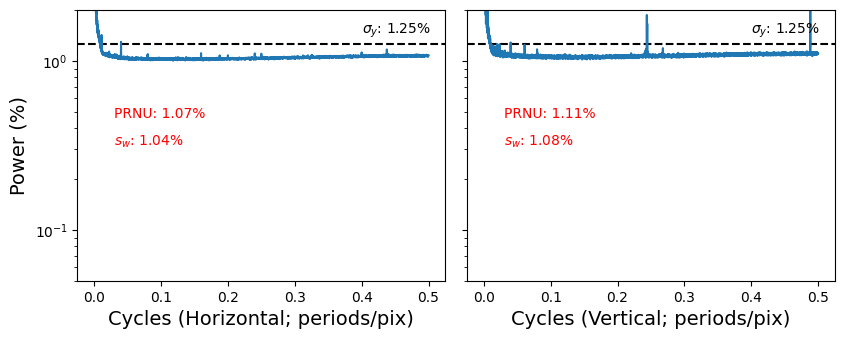

In [27]:
nonuniformity = NonuniformityCalc(gray_stack_imgs, dark_stack_imgs, dsnu_stack_imgs, num_imgs=22, do_filtering=False)
print("PRNU: ", nonuniformity.prnu)
print("DSNU: ", nonuniformity.dsnu)
nonuniformity.plot_gray_spectrograms()
# nonuniformity.plot_dsnu_spectrograms(gain=4.06)

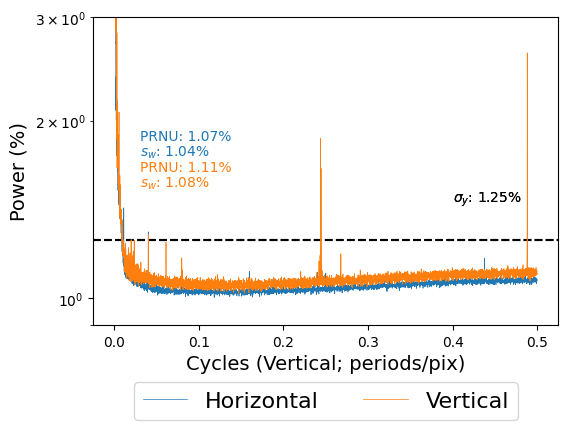

In [43]:
power_spect_horiz = nonuniformity.power_spect_horiz(img_type='gray')
power_spect_vert = nonuniformity.power_spect_vert(img_type='gray')
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6, 4))
avg = np.nanmean(nonuniformity.gray_avg_img - nonuniformity.dark_avg_img)
y_axis_horiz = np.sqrt(nonuniformity.gray_pow_spec_horiz) / avg * 100
prnu_horiz = np.sqrt(np.sum(nonuniformity.gray_pow_spec_horiz[7:-7]) / nonuniformity.N_gray - 15) / avg * 100
y_axis_vert = np.sqrt(nonuniformity.gray_pow_spec_vert) / avg * 100
prnu_vert = np.sqrt(np.sum(nonuniformity.gray_pow_spec_vert[7:-7]) / nonuniformity.M_gray - 15) / avg * 100
white_noise_horiz = np.median(y_axis_horiz)
white_noise_vert = np.median(y_axis_vert)
nonwhite_factor_horiz = (prnu_horiz / white_noise_horiz) ** 2
nonwhite_factor_vert = (prnu_vert / white_noise_vert) ** 2
ax.set_ylabel('Power (%)', fontsize=14)
sigma_y = np.sqrt(nonuniformity.gray_temp_var - nonuniformity.dark_temp_var) / avg * 100
ax.axhline(sigma_y, color='black', linestyle='dashed')
ax.text(0.4, sigma_y + 0.2, r'$\sigma_y$: ' + format(sigma_y, '.2f') + '%')
ax.axhline(sigma_y, color='black', linestyle='dashed')
ax.text(0.4, sigma_y + 0.2, r'$\sigma_y$: ' + format(sigma_y, '.2f') + '%')
ax.text(0.1, 0.6, 'PRNU: ' + format(prnu_horiz, '.2f') + '%',
            color='C0', transform=ax.transAxes)
ax.text(0.1, 0.55, r'$s_w$: ' + format(white_noise_horiz, '.2f') + '%',
            color='C0', transform=ax.transAxes)
ax.text(0.1, 0.5, 'PRNU: ' + format(prnu_vert, '.2f') + '%',
            color='C1', transform=ax.transAxes)
ax.text(0.1, 0.45, r'$s_w$: '  + format(white_noise_vert, '.2f') + '%',
            color='C1', transform=ax.transAxes)
ax.plot(np.arange(nonuniformity.N_gray//2) / nonuniformity.N_gray, y_axis_horiz[:nonuniformity.N_gray//2], label='Horizontal', linewidth=0.5)
ax.set_xlabel('Cycles (Horizontal; periods/pix)', fontsize=14)
ax.plot(np.arange(nonuniformity.M_gray//2) / nonuniformity.M_gray, y_axis_vert[:nonuniformity.M_gray//2], label='Vertical', linewidth=0.5)
ax.set_xlabel('Cycles (Vertical; periods/pix)', fontsize=14)
# ax.set_ylim(0.05, 2)
# Put legend outside of plot, on top of x axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=16)
plt.yscale('log')
ax.set_ylim(0.9, 3)
plt.show()